# Onset detection

Task: find start of all sound events in an audio recording, e.g. notes played by instruments, precussive sounds, singing voice, etc..

Onsets usually coincide with rise in energy, thus the positive differences of energies can be used as an onset detection function.


In [1]:
from __future__ import print_function, division


import numpy as np
import madmom

import os

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [3]:
FPS = 100

We use the publicly available dataset introduced in:

> Sebastian Böck, Florian Krebs and Markus Schedl,
> "Evaluating the Online Capabilities of Onset Detection Methods",
> Proceedings of the 13th International Society for Music Information Retrieval Conference (ISMIR), 2012.

[The dataset can be downloaded here](https://drive.google.com/file/d/1ICEfaZ2r_cnqd3FLNC5F_UOEUalgV7cv/view?usp=sharing) (size: 244 MB).

Please unpack the dataset into the same folder as this notebook.
If you place it somewhere else, please adjust `ONSET_PATH` accordingly.

In [4]:
ONSET_PATH = 'onsets_ISMIR_2012/'

example = 'vorbis_lalaw'

example_audio = '%s/audio/%s.flac' % (ONSET_PATH, example)
example_annotation = '%s/annotations/onsets/%s.onsets' %  (ONSET_PATH, example)
annotations = madmom.io.load_onsets(example_annotation)

### Time domain signal

In [5]:
signal = madmom.audio.Signal(example_audio)

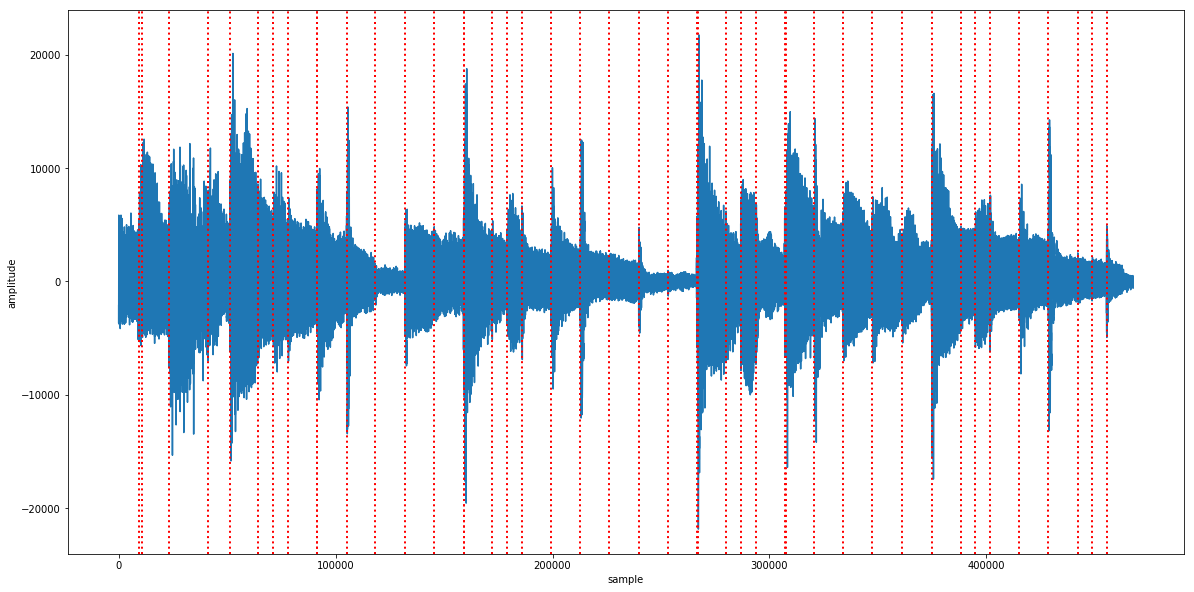

In [24]:
plt.plot(signal)
plt.xlabel('sample')
plt.ylabel('amplitude')
for ann in annotations:
    plt.axvline(x=ann * signal.sample_rate, color='r', linestyle=':', linewidth=2)

### Time-frequency representation
Instead of the raw energy of the time-domain signal, it is advantageous to use a time-frequency representation for onset detection.

We use the magnitudes of an short-time Fourier transform (STFT).
As parameters, a frame size of 2048 samples and a frame rate of 100 frames per second (fps) is chosen.
These is the default parametrisation of `madmom` and usually works quite well for many tasks.
They can be changed by supplying the classes named arguments `frame_size` and `fps` during instantiation.


In [7]:
spec = madmom.audio.Spectrogram(signal)

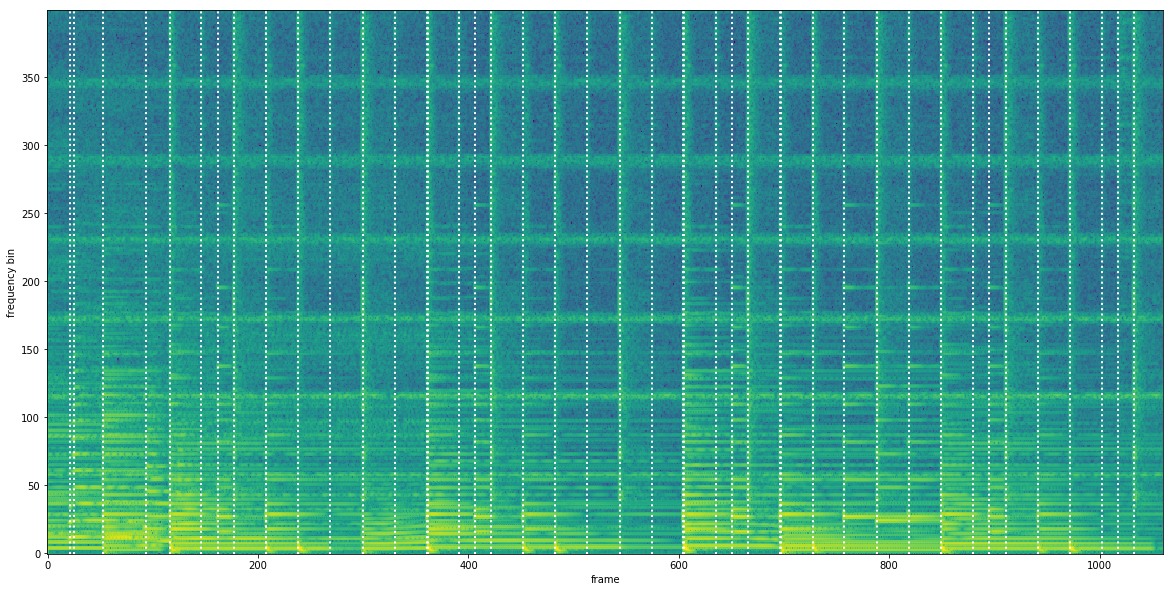

In [25]:
# logarithmically scale spectrogram for displaying purposes, see below
plt.imshow(np.log(spec).T[:400], origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
for ann in annotations:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

### Filtering

It is furthermore advantageous to filter the spectrogram with a filter of (semi-)logarithmic spacing, e.g. Mel filtering.

In [9]:
filt_spec = madmom.audio.FilteredSpectrogram(spec)

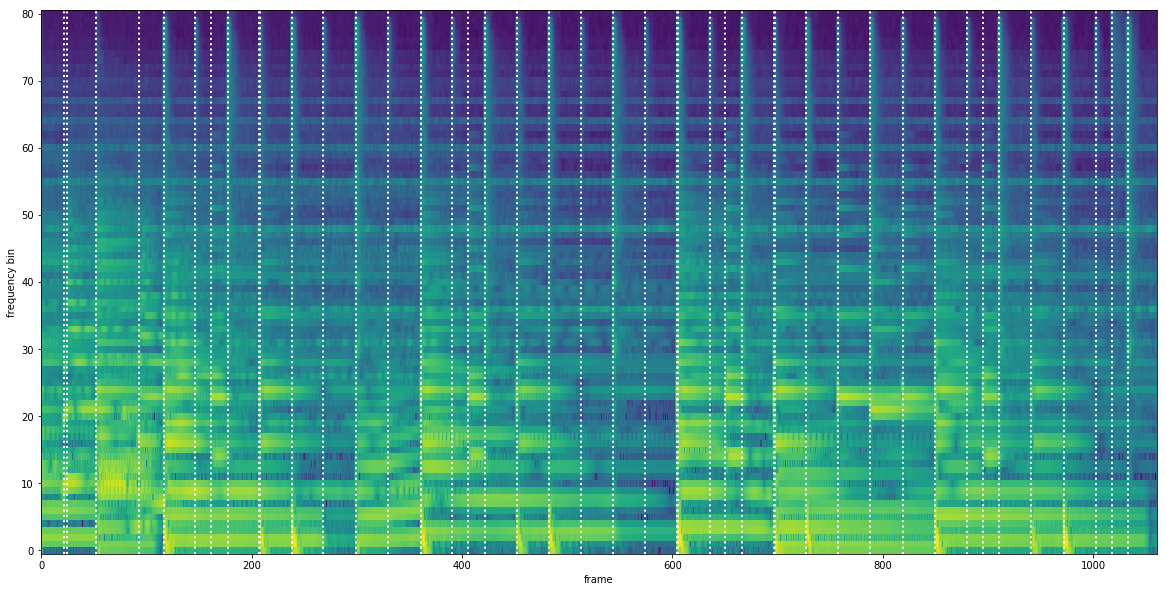

In [26]:
# logarithmically scale spectrogram for displaying purposes, see below
plt.imshow(np.log(filt_spec).T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
for ann in annotations:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

### Logarithmic scaling

Scaling the filtered magnitude spectrogram has found to perform better than a filtered logarithmically scaled spectrogram, i.e. filter first, then apply logarithmic scaling.

In [11]:
log_filt_spec = madmom.audio.LogarithmicSpectrogram(filt_spec)

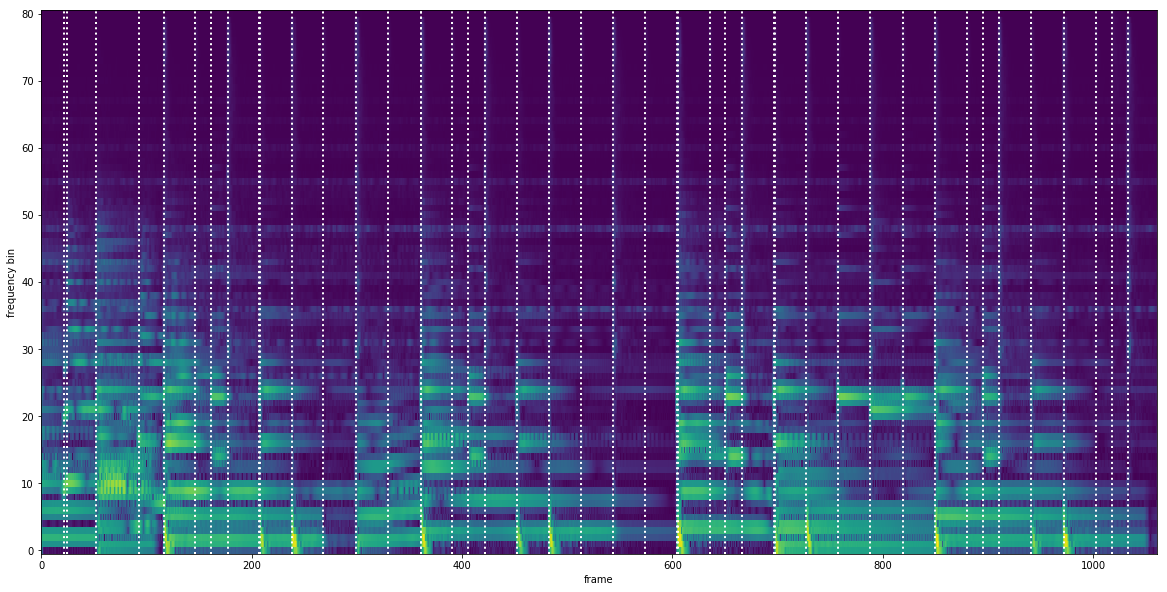

In [27]:
plt.imshow(log_filt_spec.T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
for ann in annotations:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

### Difference in time

Since onsets positions are characterised by a rise in energy, we compute the differences of two adjacent frames.

In [13]:
log_filt_spec_flux = madmom.audio.SpectrogramDifference(log_filt_spec, positive_diffs=True)

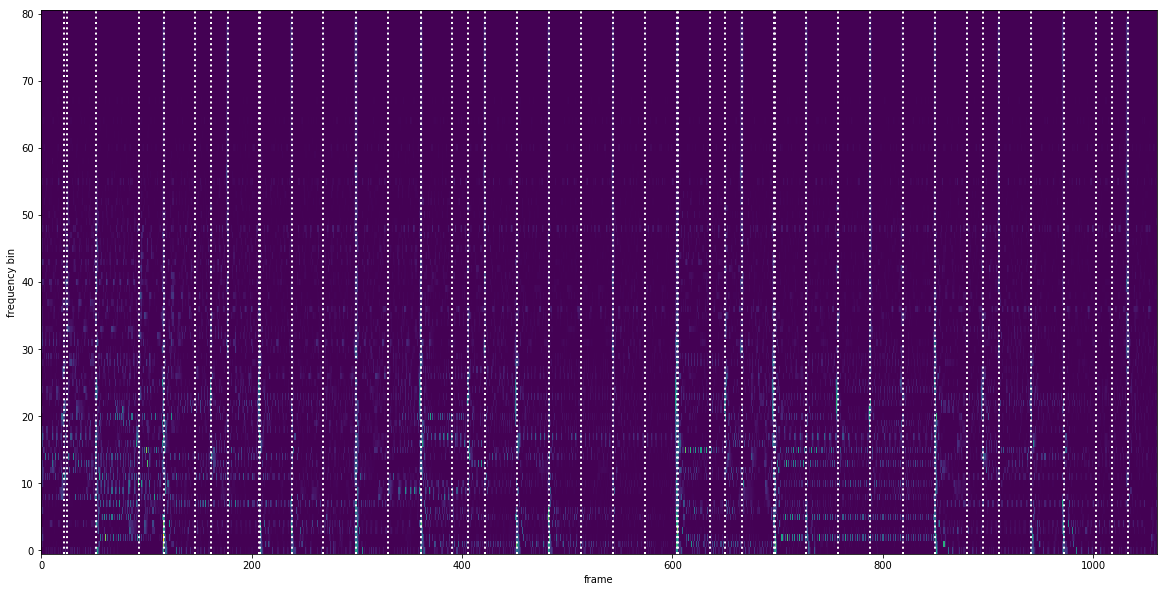

In [42]:
plt.imshow(log_filt_spec_flux.T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
for ann in annotations:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

### Spectral Flux

Spectral Flux is defined as the sum of all these positive differences.



In [15]:
spectral_flux = np.sum(log_filt_spec_flux, axis=1)

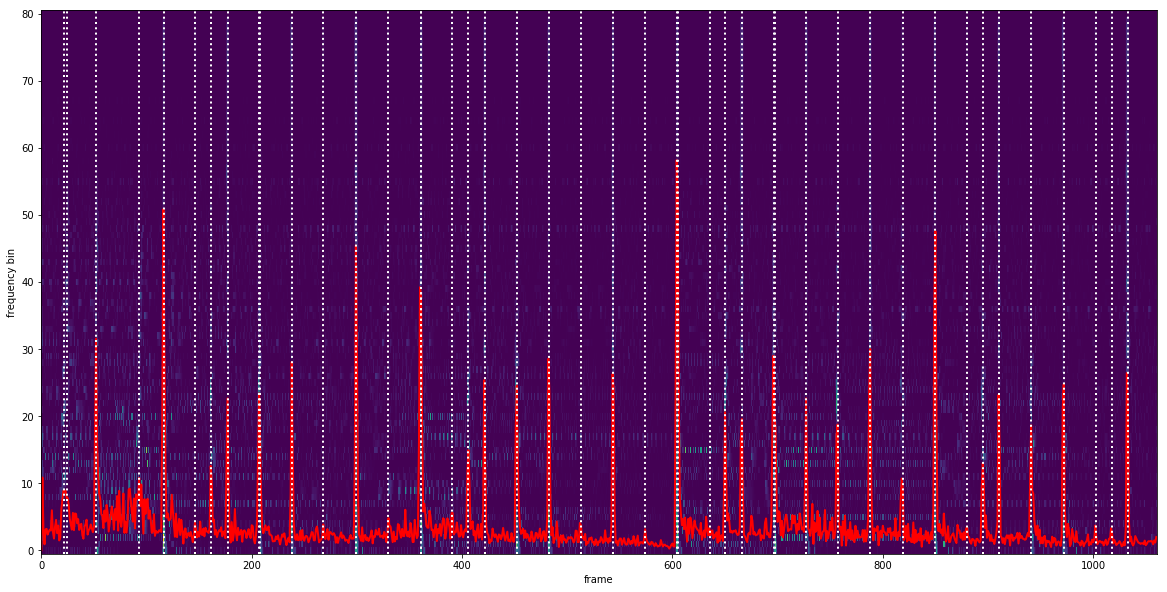

In [45]:
plt.imshow(log_filt_spec_flux.T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
plt.plot(spectral_flux * 3, 'r', linewidth=2)
for ann in annotations:
    plt.axvline(x=ann * FPS, color='w', linestyle=':', linewidth=2)

### Peak picking

To obtain the final onsets, peaks in the onset detection function must be picked.
A standard way is to compute a running average and use all peaks above this running average and a certain threshold as onsets.

In [31]:
onsets = madmom.features.onsets.peak_picking(spectral_flux, threshold=1.25, pre_max=1,
                                             post_max=5, pre_avg=15, post_avg=0)

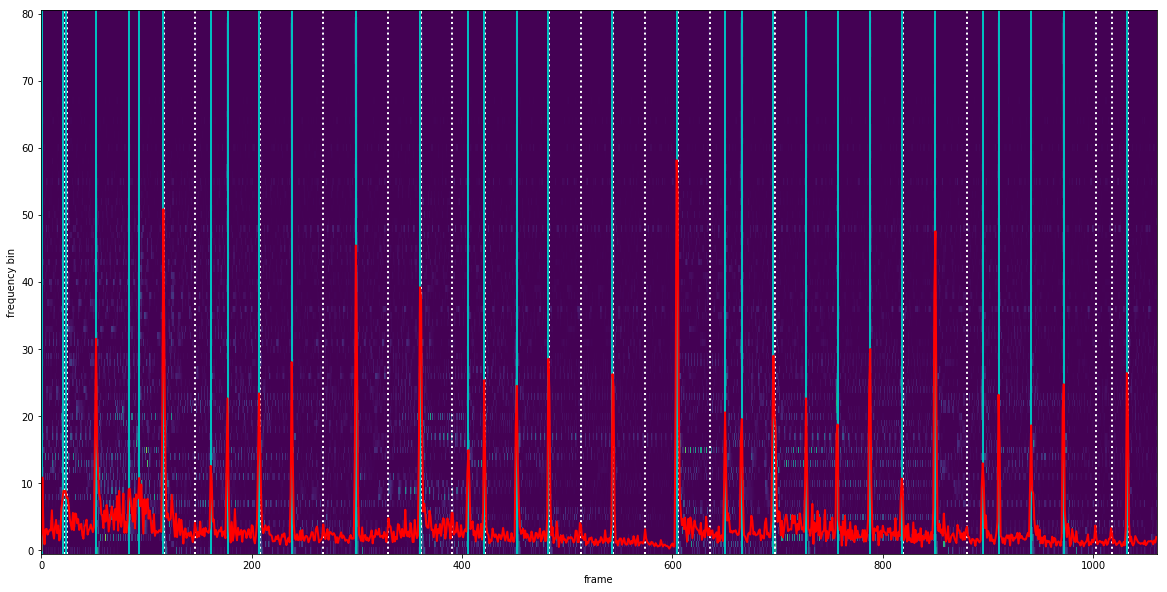

In [40]:
plt.imshow(log_filt_spec_flux.T, origin='lower', aspect='auto')
plt.xlabel('frame')
plt.ylabel('frequency bin')
for ann in annotations:
    plt.axvline(ann * FPS, color='w', linestyle=':', linewidth=2)
for o in onsets:
    plt.axvline(o, color='c', linestyle='-', linewidth=2)
plt.plot(spectral_flux * 3, 'r', linewidth=2)

### Perform onset detection on complete dataset

In [19]:
from functools import partial

peak_picking = partial(madmom.features.onsets.peak_picking, threshold=1.25,
                       pre_max=1, post_max=5, pre_avg=15, post_avg=0)

In [20]:
audio_files = madmom.utils.search_files('%s/audio/' % ONSET_PATH, '.flac')


for audio in audio_files:
    # process audio
    log_filt_spec = madmom.audio.LogarithmicFilteredSpectrogram(audio)
    log_filt_spec_diff = madmom.audio.SpectrogramDifference(log_filt_spec, positive_diffs=True)
    spectral_flux = np.sum(log_filt_spec_diff, axis=1)
    # detect onsets and convert timing
    onsets = peak_picking(spectral_flux)
    onsets = np.array(onsets, dtype=np.float)
    onsets /= FPS
    # save them
    filename = os.path.splitext(audio)[0]
    madmom.io.write_onsets(onsets, filename + '.onsets.txt')

### Evaluate the performance

In [21]:
def evaluate_onsets(detections, annotations, verbose=False, ann_suffix='.onsets', det_suffix='.onsets.txt'):
    evals = []
    for ann in annotations:
        name = os.path.basename(ann)
        # get the matching detection files
        matches = madmom.utils.match_file(ann, detections, ann_suffix, det_suffix)
        det = madmom.io.load_onsets(matches[0])
        ann = madmom.io.load_onsets(ann)
        e = madmom.evaluation.onsets.OnsetEvaluation(
            det, ann, combine=0.03, window=0.025, name=name)
        evals.append(e)
        if verbose:
            print(e)
    se = madmom.evaluation.onsets.OnsetSumEvaluation(evals)
    me = madmom.evaluation.onsets.OnsetMeanEvaluation(evals)
    return se, me

In [22]:
detection_files = madmom.utils.search_files('%s/audio/' % ONSET_PATH, '.onsets.txt')
annotation_files = madmom.utils.search_files('%s/annotations/onsets/' % ONSET_PATH, '.onsets')

se, me = evaluate_onsets(detection_files, annotation_files)
print(se)
print(me)

sum for 321 files
  Onsets: 25827 TP: 19061 FP:  4115 FN:  6766 Precision: 0.822 Recall: 0.738 F-measure: 0.778 mean:  -4.2 ms std:   7.6 ms
mean for 321 files
  Onsets: 80.46 TP: 59.38 FP: 12.82 FN: 21.08 Precision: 0.813 Recall: 0.772 F-measure: 0.774 mean:  -4.5 ms std:   6.6 ms
